# Fast-reversion Heston FX demo

### 1. Surface generation using FT

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from frh_fx import mpl, blk, nig, frh, uts, mdl
# remove mdl in favour of sim
% matplotlib inline

In [2]:
mpl.config(scale=1.5,print_keys=False)

First let us look at an FRH triangle of implied volatility surface.

Set maturities

In [3]:
t = np.array([1/52,1/12,3/12,6/12,1]).T

Set model parameters

In [4]:
σ1,ρ1 = 0.10, 0.2
σ2,ρ2 = 0.10,-0.5
γ = 1
ρ = 0.5

Translate to NIG parameters

In [5]:
α1,β1,δ1,μ1 = frh.nig_params(σ1,ρ1,γ)
α2,β2,δ2,μ2 = frh.nig_params(σ2,ρ2,γ)

Obtain cross NIG parameters

In [6]:
θ1 = α1,β1,δ1
θ2 = α2,β2,δ2
α3,β3,δ3,μ3 = nig.cross_params(θ1,θ2,ρ)
θ3 = α3,β3,δ3

Set some sensible log-strikes for a surface

In [7]:
k = uts.get_logstrikes(t)

Compute prices, then volatilities, on this surface

In [8]:
p1 = nig.price(k,θ1,t)
p2 = nig.price(k,θ2,t)
p3 = nig.price(k,θ3,t)

In [9]:
BS1a = blk.surface(k,t,p1)
BS2a = blk.surface(k,t,p2)
BS3a = blk.surface(k,t,p3)

Now plot

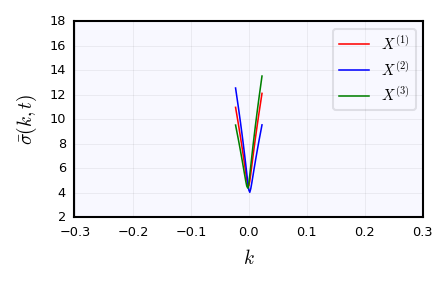

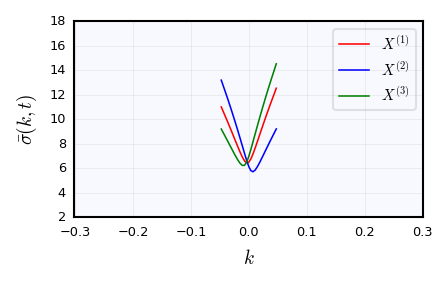

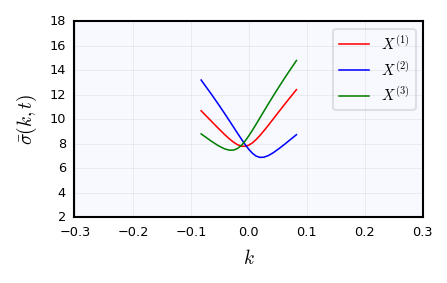

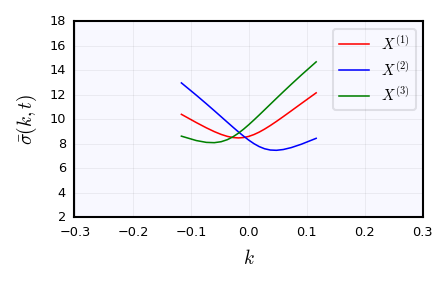

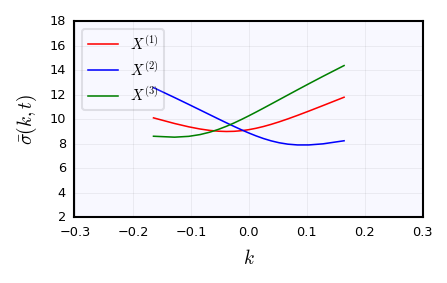

In [10]:
for i in range(len(k[:,0])):
    plot,axes = plt.subplots()
    axes.plot(k[i,:],100*BS1a[i,:],'r')
    axes.plot(k[i,:],100*BS2a[i,:],'b')
    axes.plot(k[i,:],100*BS3a[i,:],'g')
    axes.legend([r'$X^{(1)}$',
                 r'$X^{(2)}$',
                 r'$X^{(3)}$'])
    axes.set_xlabel(r'$k$')
    axes.set_ylabel(r'$\bar{\sigma}(k,t)$')
    axes.set_xlim([-0.301,0.301])
    axes.set_ylim([2,18]);

In [11]:
# uts.export_surface(k,t,BS1a)

### 2. Verification using MC

Now we should check we do obtain these surfaces using a Monte Carlo simulation.

In [12]:
T = 1.0
m = 2**18
n = 2**0
ρ = 0.5
t = np.linspace(0,T,n+1)
Δ = T/n

In [13]:
np.random.seed(0)
ϕ1 = np.random.normal(size=(m,n))
ϕ2 = ρ*ϕ1 + np.sqrt(1 - ρ**2)*np.random.normal(size=(m,n))
ϕ3 = np.random.normal(size=(m,n))

In [14]:
σ1,ρ1 = 0.10, 0.2
σ2,ρ2 = 0.10,-0.5
γ = 1

In [15]:
α1,β1,δ1,μ1 = frh.nig_params(σ1,ρ1,γ)
α2,β2,δ2,μ2 = frh.nig_params(σ2,ρ2,γ)

In [16]:
v = nig.inverse_gaussian(Δ/γ,1/γ,size=(m,n))
v1 = σ1**2*(1 - ρ1**2)*v
v2 = σ2**2*(1 - ρ2**2)*v

In [17]:
θ1 = α1,β1,δ1
θ2 = α2,β2,δ2
α3,β3,δ3,μ3 = nig.cross_params(θ1,θ2,ρ)
θ3 = α3,β3,δ3

In [18]:
# Appears to work !!!
# ω = np.sqrt(np.sqrt((α2**2 - β2**2)/(α1**2 - β1**2))*δ1/δ2)
# β3 = (ω**2*β1 + ω*ρ - β2 - 1)/(ω**2 - 2*ω*ρ + 1)
# γ3 = np.sqrt(α2**2 - (β2 + 1)**2)/np.sqrt(ω**2 - 2*ω*ρ + 1) # abuse
# δ3 = np.sqrt(ω**2 - 2*ω*ρ + 1)*δ2
np.random.seed(0)
v3 = nig.inverse_gaussian(δ3*Δ,np.sqrt(α3**2 - β3**2),size=(m,n))
ϕ3 = np.random.normal(size=(m,n))
dx3 = β3*v3 + np.sqrt(v3)*ϕ3
x3 = np.hstack((np.zeros((m,1)),np.cumsum(dx3,axis=1)))
# X3_2 = np.exp(x3)/np.mean(np.exp(x3),axis=0)

In [19]:
dx1_0 = β1*v1 + np.sqrt(v1)*ϕ1 + μ1*Δ
dx2_0 = β2*v2 + np.sqrt(v2)*ϕ2 + μ2*Δ
x1_0 = np.hstack((np.zeros((m,1)),np.cumsum(dx1_0,axis=1)))
x2_0 = np.hstack((np.zeros((m,1)),np.cumsum(dx2_0,axis=1)))
X1_0 = np.exp(x1_0)/np.mean(np.exp(x1_0),axis=0)
X2_0 = np.exp(x2_0)/np.mean(np.exp(x2_0),axis=0)

In [20]:
X3_0 = X1_0/X2_0

In [21]:
t = np.array([1]).T
k = uts.get_logstrikes(t)

In [22]:
# # Δ = np.linspace(0.05,0.95,19)
# Δ = np.linspace(0.01,0.99,99)
# k = norm.ppf(Δ)*0.5*(σ1 + σ2)*np.sqrt(T)
# k = k[np.newaxis,:]
# t = np.array([T])

In [23]:
# Can update prices function now
P1 = mdl.prices(X1_0,k,t,n=n)
P2 = mdl.prices(X2_0,k,t,n=n)
# P3_2 = mdl.prices(X3_2,k,t,n=n)
P3 = mdl.prices2(X3_0,k,t,n=n,N=X2_0)

In [24]:
BS1b = blk.surface(k,t,P1)
BS2b = blk.surface(k,t,P2)
BS3b = blk.surface(k,t,P3)
# BS3_2 = blk.surface(k,t,P3_2)

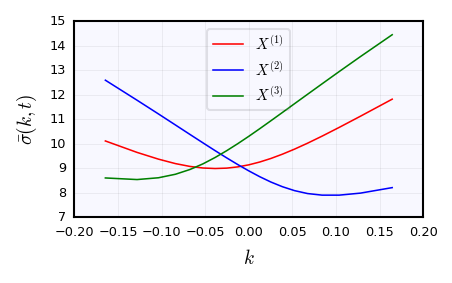

In [25]:
plot,axes = plt.subplots()
axes.plot(k[0,:],100*BS1b[0,:],'r')
axes.plot(k[0,:],100*BS2b[0,:],'b')
axes.plot(k[0,:],100*BS3b[0,:],'g')
# axes.plot(k[0,:],100*BS3_2[0,:],'g:')
axes.legend([r'$X^{(1)}$',
             r'$X^{(2)}$',
             r'$X^{(3)}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$');

Now plot comparitive charts

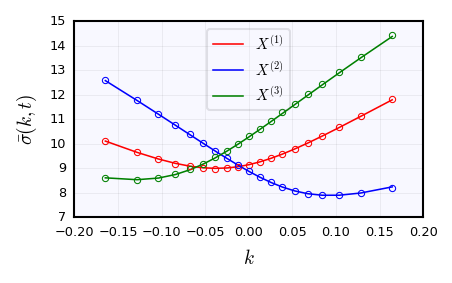

In [26]:
plot,axes = plt.subplots()
axes.plot(k[0,:],100*BS1a[-1,:],'r')
axes.plot(k[0,:],100*BS2a[-1,:],'b')
axes.plot(k[0,:],100*BS3a[-1,:],'g')
axes.plot(k[0,:],100*BS1b[0,:],'ro')
axes.plot(k[0,:],100*BS2b[0,:],'bo')
axes.plot(k[0,:],100*BS3b[0,:],'go')
axes.legend([r'$X^{(1)}$',
             r'$X^{(2)}$',
             r'$X^{(3)}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$');

### Time-dependent params

Finally we demonstrate the time-dependent case, and another interesting symmetry.

In [27]:
t = np.linspace(0,1,101)
rho = -0.9
def σ(t): return 0.1
def ρ(t): return rho
def γ(t): return t**0.5
θ = σ,ρ,γ

In [28]:
T = np.array([1/252,1])
k = uts.get_logstrikes(T)

In [29]:
p = frh.price(k,T,θ)

In [30]:
BS = blk.surface(k,T,p)

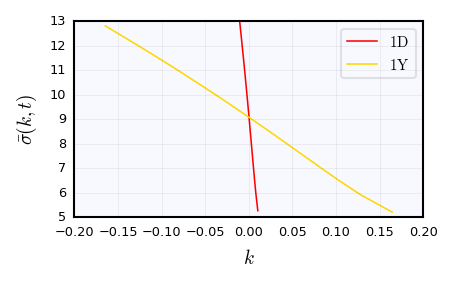

In [31]:
plot,axes = plt.subplots()
c = ['r','gold','g','b']
for i in range(2):
    axes.plot(k[i,:],100*BS[i,:],c[i])
axes.legend([r'$\mathrm{1D}$',
             r'$\mathrm{1Y}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$');

In [32]:
Δ = uts.get_deltas(BS,k,T,ρ=rho)

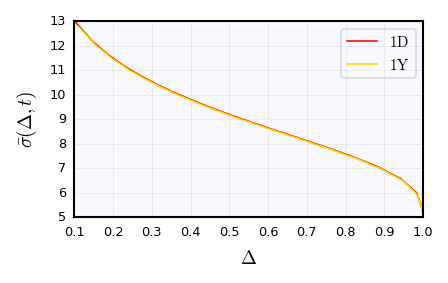

In [33]:
plot,axes = plt.subplots()
c = ['r','gold','g','b']
for i in range(2):
    axes.plot(Δ[i,:],100*BS[i,:],c[i])
axes.legend([r'$\mathrm{1D}$',
             r'$\mathrm{1Y}$'])
axes.set_xlabel(r'$\Delta$')
axes.set_ylabel(r'$\bar{\sigma}(\Delta,t)$');